In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath("..")))
from CS224W_Project import *

In [2]:
# https://stackoverflow.com/questions/35569042/ssl-certificate-verify-failed-with-python3
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [86]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from typing import Optional
import yaml
import math
import networkx as nx
from collections import defaultdict

In [4]:
from CS224W_Project.src.utils.data_utils import *

## Import Graphs

In [7]:
DATA_PATH = os.path.join(ROOT_DIR, "data")
DATA_PATH

'/Users/sleeper/Desktop/CS 224W/Project/CS224W_Project/data'

In [16]:
methods = {"metr": "METR-LA", "pems": "PEMS-BAY"}

In [17]:
adj_mats = {
    method: np.load(os.path.join(DATA_PATH, f"adj_mat_{method}.npy"))
    for method in methods.keys()
}

In [18]:
adj_mats["metr"].shape, adj_mats["pems"].shape

((207, 207), (325, 325))

## Symmetry test

In [44]:
np.all(adj_mats["metr"] - adj_mats["metr"].T < 1e-3)

False

In [45]:
np.all(adj_mats["pems"] - adj_mats["pems"].T < 1e-3)

False

We can see that the graphs are not symmetric:

In [22]:
adj_mats["metr"][:10, :10].round(2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.39, 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.  ],
       [0.  , 0.72, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.63, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.63, 1.  , 0.  , 0.14, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.89, 0.36, 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],
      dtype=float32)

In [42]:
adj_mats["pems"][:10, :10].round(2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.61, 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],
      dtype=float32)

## Adjacecy Matrix Graphs

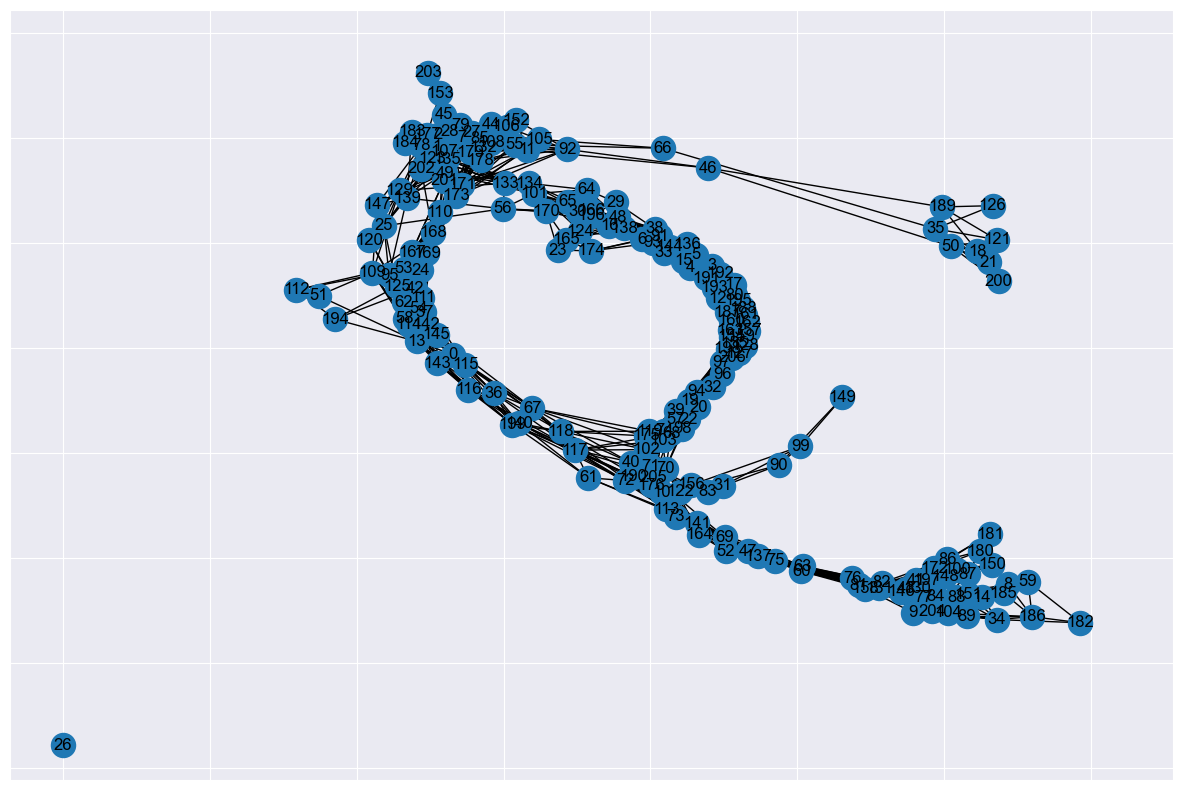

In [40]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
nx.draw_networkx(nx.from_numpy_array(adj_mats["metr"] - np.eye(adj_mats["metr"].shape[0])), ax=ax)

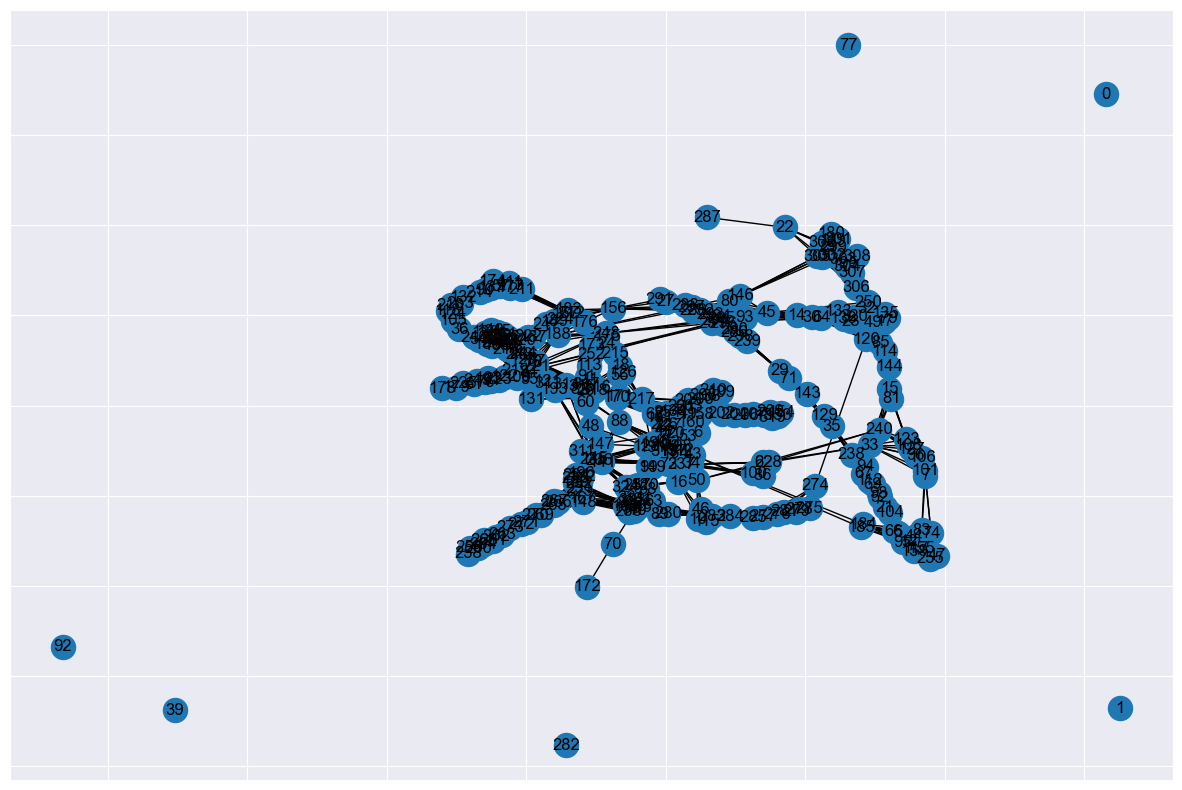

In [41]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
nx.draw_networkx(nx.from_numpy_array(adj_mats["pems"] - np.eye(adj_mats["pems"].shape[0])), ax=ax)

## Adjacecy Matrix Heatmaps

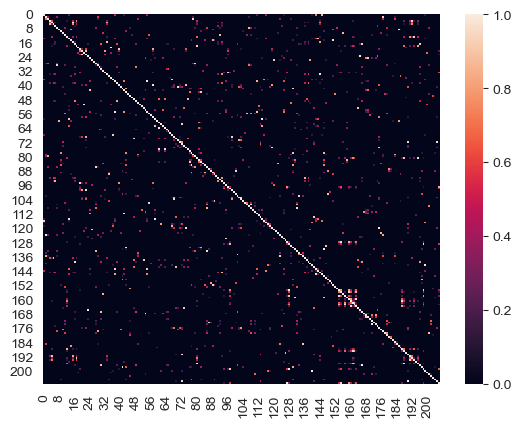

In [25]:
_ = sns.heatmap(adj_mats["metr"])

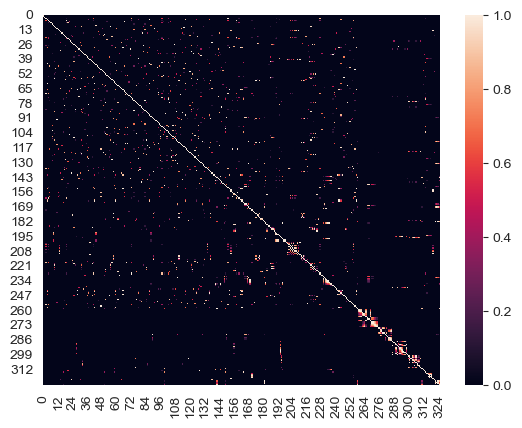

In [26]:
_ = sns.heatmap(adj_mats["pems"])

## Graph Fourier Transform with Eigendecomp on Averaged Adjacency

## Graph Fourier Transform with SVD

In [104]:
svd = dict()
for method, adj_mat in adj_mats.items():
    svecs_l, svals, svecs_r = np.linalg.svd(adj_mat)
    svd[method] = {"svals": svals, "svecs_l": svecs_l, "svecs_r": svecs_r}

### Scree Plot

In [108]:
def plot_svd_screeplot(svals: np.ndarray, method: str = None):
    contribution = np.round(np.cumsum(svals) / svals.sum(), 2)
    quantiles = {p: np.argmax(contribution >= p) for p in {0.5, 0.75, 0.9}}
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plt.tight_layout()
    ax.plot(range(svals.shape[0]), svals)
    ax.set_xlim(-3, svals.shape[0] + 3)
    ax.set_ylim(-0.1, svals.max() + 0.1)
    ax.set_ylabel("Singular value")
    ax.set_xlabel("Order")
    ax.fill_between(
        x=range(quantiles[0.5] + 1), 
        y1=0, 
        y2=svals[range(quantiles[0.5] + 1)], 
        alpha=0.5, 
        label="50% explained"
    )
    ax.fill_between(
        x=range(quantiles[0.5], quantiles[0.75] + 1), 
        y1=0, 
        y2=svals[range(quantiles[0.5], quantiles[0.75] + 1)], 
        alpha=0.25, 
        label="75% explained"
    )
    ax.fill_between(
        x=range(quantiles[0.75], quantiles[0.9] + 1), 
        y1=0, 
        y2=svals[range(quantiles[0.75], quantiles[0.9] + 1)], 
        alpha=0.15, 
        label="90% explained"
    )
    ax.legend()
    title = "SVD Scree Plot"
    if method is not None:
        title += f" for the Adjacency Matrix of {methods[method]}"
    ax.set_title(title)

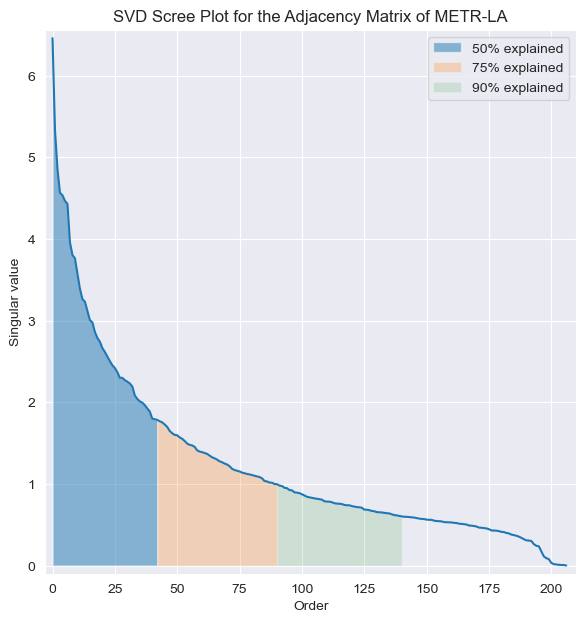

In [109]:
method = "metr"
plot_svd_screeplot(svd[method]["svals"], method=method)

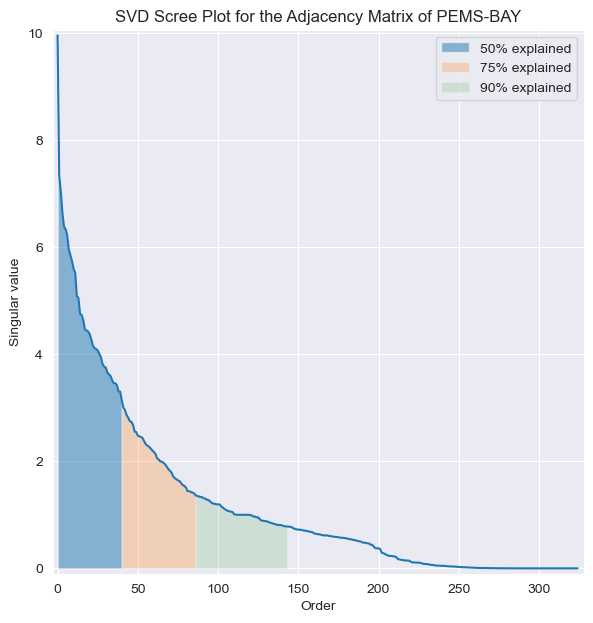

In [110]:
method = "pems"
plot_svd_screeplot(svd[method]["svals"], method=method)

### Graph Fourier Basis